In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random



from collections import Counter
from scipy.stats import mode

import sys
import os

# Add the directory containing 'aug.py' to the Python path
#sys.path.append(os.path.abspath(r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\day7to10_simclr_pred"))
#from aug import one_Original,two_Ori_Hori_blur,three_Orig_Veri_sharp,four_Orig_verihori_sharp_blur,five_only_D10_Hori,six_only_D10_veri,seven_D10_verihori,ate_only_D7_Hori,nine_only_D7_veri,ten_D7_verihori,eleven_Orig_R90_sharp_blur,twelve_Orig_R270_sharp_blur,thirteen_Orig_HoriR90_sharp_blur,fourteen_Orig_HoriR270_sharp_blur,fifteen_D7_R90,sixteen_D7_R270,seventeen_D7_HoriR90,ateen_D7_HoriR270,ninteen_D10_R90,twenty_D10_R270,twentyone_D10_HoriR90,twentytwo_D10_HoriR270

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
full_model_path =  r'C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\SimCLR_base_models\ohnecontrast_balancedResize_simclr_modelepoch245.pth' 

In [5]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay,max_epochs):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            #self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, inference_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(inference_loader)
        avg_top1_acc = total_top1_acc / len(inference_loader)
        avg_top5_acc = total_top5_acc / len(inference_loader)
        avg_mean_pos = total_mean_pos / len(inference_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [6]:
simclr_model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4,max_epochs=245)
simclr_model.load_state_dict(torch.load(full_model_path))
simclr_model.to(device)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_12276\1467178467.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model.load_state_dict(torch.load(full_model_path))


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [7]:
import random
import torchvision.transforms.functional as TF

In [7]:
ex_close_d7 = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\less_exp2\day7'
ex_close_d10 = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\less_exp2\day10' 

In [8]:
sd_close_d7 = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\ds_closeto_sd\day7'
sd_close_d10 = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\ds_closeto_sd\day10' 

In [8]:
# Specify paths for both day7 and day10 folders

con_day7_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\control130_all\combined\day7'
con_day10_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\control130_all\combined\day10'

In [9]:
ex_day7_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\exploded38\day7'
ex_day10_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\exploded38\day10'

In [10]:
sd_day7_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\sd_ds\single_dose\RBT 01.04_gant61\Before (untreated) Day7\GANT61'
sd_day10_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\sd_ds\single_dose\RBT 01.04_gant61\After Day10\GANT61'

In [9]:
from torchvision.transforms import Resize

In [10]:
class Original(Dataset):
    def __init__(self, day7_dir, day10_dir):
        self.day7_files = {os.path.basename(file): os.path.join(day7_dir, file) for file in os.listdir(day7_dir)if file.endswith(('.tiff', '.tif'))}
        self.day10_files = {os.path.basename(file): os.path.join(day10_dir, file) for file in os.listdir(day10_dir) if file.endswith(('.tiff', '.tif'))}
      
        # Ensure all day7 files have a corresponding day10 file
        self.common_files = list(self.day7_files.keys())
        assert set(self.common_files) <= set(self.day10_files.keys()), "Mismatch between day7 and day10 filenames."
        self.resize = Resize((96, 96))

    def __len__(self):
        return len(self.common_files)

    def __getitem__(self, idx):
        filename = self.common_files[idx]
        day7_img_path = self.day7_files[filename]
        day10_img_path = self.day10_files[filename]

        # Load the images
        day7_img = tiff.imread(day7_img_path)
        day10_img = tiff.imread(day10_img_path)

        # Ensure the images have 3 layers (channels)
        if day7_img.shape[0] != 3:
            raise ValueError(f"Day7 image at {day7_img_path} does not have exactly 3 layers. Found shape: {day7_img.shape}.")
        if day10_img.shape[0] != 3:
            raise ValueError(f"Day10 image at {day10_img_path} does not have exactly 3 layers. Found shape: {day10_img.shape}.")

        # Normalize and convert both images
        day7_img = day7_img.astype(np.float32) / 65535.0
        day10_img = day10_img.astype(np.float32) / 65535.0

        # Convert to tensors
        day7_img = torch.tensor(day7_img, dtype=torch.float32)
        day10_img = torch.tensor(day10_img, dtype=torch.float32)

        day7_img = self.resize(day7_img)
        day10_img = self.resize(day10_img)


        return day7_img, day10_img, day10_img_path




In [ ]:
# Create the dataset
sd_dataset = Original(sd_day7_dir, sd_day10_dir) 
batch_size = 16
# Define DataLoaders
sd_loader = DataLoader(sd_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu

In [13]:
# Create the dataset
ex_dataset = Original(ex_day7_dir, ex_day10_dir) 
batch_size = 16
# Define DataLoaders
ex_loader = DataLoader(ex_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu

In [14]:
con_dataset = Original(con_day7_dir, con_day10_dir) 
batch_size = 16
# Define DataLoaders
con_loader = DataLoader(con_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu

In [11]:
ex_close_dataset = Original(ex_close_d7, ex_close_d10) 
batch_size = 16
# Define DataLoaders
ex_close_loader = DataLoader(ex_close_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu

In [12]:
sd_close_dataset = Original(sd_close_d7, sd_close_d10) 
batch_size = 16
# Define DataLoaders
sd_close_loader = DataLoader(sd_close_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu

In [13]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all paired images
    day7_feats = []
    day10_feats = []
    d10_imgpaths = []
    for batch_day7_imgs, batch_day10_imgs, batch_d10_imgpath in tqdm(dataloader):
        # Move images to the device
        batch_day7_imgs = batch_day7_imgs.to(device)
        batch_day10_imgs = batch_day10_imgs.to(device)

        # Extract features for day7 and day10 images
        batch_day7_feats = network(batch_day7_imgs)
        batch_day10_feats = network(batch_day10_imgs)

        print(f"Day 7 Batch features shape: {batch_day7_feats.shape}")
        print(f"Day 10 Batch features shape: {batch_day10_feats.shape}")

        # Collect features
        day7_feats.append(batch_day7_feats.detach().cpu())
        day10_feats.append(batch_day10_feats.detach().cpu())

        d10_imgpaths.extend(batch_d10_imgpath)

    # Concatenate features
    day7_feats = torch.cat(day7_feats, dim=0)
    day10_feats = torch.cat(day10_feats, dim=0)

    print(f"Day 7 Features shape after concatenation: {day7_feats.shape}")
    print(f"Day 10 Features shape after concatenation: {day10_feats.shape}")

    return day7_feats, day10_feats, d10_imgpaths


In [16]:
# Extract features from the training dataset
ex7, ex10, exd10_paths = prepare_data_features(simclr_model, ex_loader)

 33%|███▎      | 1/3 [00:01<00:03,  1.78s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


In [17]:
# Extract features from the training dataset
cond7, cond10, cond10_paths = prepare_data_features(simclr_model, con_loader)

 11%|█         | 1/9 [00:01<00:11,  1.45s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 22%|██▏       | 2/9 [00:02<00:10,  1.46s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 33%|███▎      | 3/9 [00:04<00:08,  1.43s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 44%|████▍     | 4/9 [00:05<00:07,  1.44s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 56%|█████▌    | 5/9 [00:07<00:05,  1.42s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 6/9 [00:08<00:04,  1.42s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 78%|███████▊  | 7/9 [00:09<00:02,  1.40s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 89%|████████▉ | 8/9 [00:11<00:01,  1.43s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 9/9 [00:11<00:00,  1.30s/it]

Day 7 Batch features shape: torch.Size([2, 512])
Day 10 Batch features shape: torch.Size([2, 512])
Day 7 Features shape after concatenation: torch.Size([130, 512])
Day 10 Features shape after concatenation: torch.Size([130, 512])


In [18]:
# Extract features from the training dataset
sd7, sd10, sd10_paths = prepare_data_features(simclr_model, sd_loader)

 50%|█████     | 1/2 [00:01<00:01,  1.55s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 2/2 [00:02<00:00,  1.45s/it]

Day 7 Batch features shape: torch.Size([13, 512])
Day 10 Batch features shape: torch.Size([13, 512])
Day 7 Features shape after concatenation: torch.Size([29, 512])
Day 10 Features shape after concatenation: torch.Size([29, 512])


In [14]:
sd7_close, sd10_close, sd10_close_paths = prepare_data_features(simclr_model, sd_close_loader)

 50%|█████     | 1/2 [00:01<00:01,  1.51s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Day 7 Batch features shape: torch.Size([2, 512])
Day 10 Batch features shape: torch.Size([2, 512])
Day 7 Features shape after concatenation: torch.Size([18, 512])
Day 10 Features shape after concatenation: torch.Size([18, 512])


In [15]:
ex7_close, ex10_close, ex10_close_paths = prepare_data_features(simclr_model, ex_close_loader)

100%|██████████| 1/1 [00:00<00:00,  5.13it/s]

Day 7 Batch features shape: torch.Size([2, 512])
Day 10 Batch features shape: torch.Size([2, 512])
Day 7 Features shape after concatenation: torch.Size([2, 512])
Day 10 Features shape after concatenation: torch.Size([2, 512])


In [19]:
import torch

# Save features and paths
torch.save({"sd7": sd7, "sd10": sd10, "sd10_paths": sd10_paths}, "sd_features.pt")
torch.save({"cond7": cond7, "cond10": cond10, "cond10_paths": cond10_paths}, "control_features.pt")
torch.save({"ex7": ex7, "ex10": ex10, "exd10_paths": exd10_paths}, "ex_features.pt")


In [16]:
torch.save({"ex7_close": ex7_close, "ex10_close": ex10_close, "ex10_close_paths": ex10_close_paths}, "ex_close_features.pt")
torch.save({"sd7_close": sd7_close, "sd10_close": sd10_close, "sd10_close_paths": sd10_close_paths}, "sd_close_features.pt")

In [17]:
# Load features and paths
sd_data = torch.load("sd_features.pt")
cond_data = torch.load("control_features.pt")
ex_data = torch.load("ex_features.pt")

sd7 = sd_data["sd7"]
sd10 = sd_data["sd10"]
sd10_paths = sd_data["sd10_paths"]

cond7 = cond_data["cond7"]
cond10 = cond_data["cond10"]
cond10_paths = cond_data["cond10_paths"]

ex7 = ex_data["ex7"]
ex10 = ex_data["ex10"]
ex10_paths = ex_data["exd10_paths"]


C:\Users\k54739\AppData\Local\Temp\ipykernel_12276\2689076763.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd_data = torch.load("sd_features.pt")
C:\Users\k54739\AppD

In [18]:
ex_close_data = torch.load("ex_close_features.pt")
sd_close_data = torch.load("sd_close_features.pt")

sd7_close = sd_close_data["sd7_close"]
sd10_close = sd_close_data["sd10_close"]
sd10_close_paths = sd_close_data["sd10_close_paths"]

ex7_close = ex_close_data["ex7_close"]
ex10_close = ex_close_data["ex10_close"]
ex10_close_paths = ex_close_data["ex10_close_paths"]

C:\Users\k54739\AppData\Local\Temp\ipykernel_12276\3824563916.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ex_close_data = torch.load("ex_close_features.pt")
C:\Users

In [19]:
print(sd7.shape)
print(sd10.shape)
print(len(sd10_paths))

torch.Size([29, 512])
torch.Size([29, 512])
29


In [20]:
print(ex7.shape)
print(ex10.shape)
print(len(ex10_paths))

torch.Size([38, 512])
torch.Size([38, 512])
38


In [21]:
print(cond7.shape)
print(cond10.shape)
print(len(cond10_paths))

torch.Size([130, 512])
torch.Size([130, 512])
130


In [22]:
print(sd7_close.shape)
print(sd10_close.shape)
print(len(sd10_close_paths))

torch.Size([18, 512])
torch.Size([18, 512])
18


In [23]:
print(ex7_close.shape)
print(ex10_close.shape)
print(len(ex10_close_paths))

torch.Size([2, 512])
torch.Size([2, 512])
2


In [24]:
sd7_min = torch.load('sd7_min.pt')
sd7_max = torch.load('sd7_max.pt')
sd10_min = torch.load('sd10_min.pt')
sd10_max = torch.load('sd10_max.pt')

C:\Users\k54739\AppData\Local\Temp\ipykernel_12276\474620549.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd7_min = torch.load('sd7_min.pt')
C:\Users\k54739\AppData\L

In [41]:
print(sd10_min.shape)  # Should output (512,)
print(sd10_max.shape) 
print(sd7_min.shape)  # Should output (512,)
print(sd7_max.shape) # Should output (512,)



torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])


In [40]:
sd10_max

tensor(8.5157)

In [25]:
def min_max_d7(data):
    return (data - sd7_min) / (sd7_max - sd7_min)

In [26]:
def min_max_d10(data):
    return (data - sd10_min) / (sd10_max - sd10_min)

In [27]:
cond7_minmax = min_max_d7(cond7)
cond10_minmax = min_max_d10(cond10)

In [28]:
ex7_minmax = min_max_d7(ex7)
ex10_minmax = min_max_d10(ex10)

In [29]:
sd7_minmax = min_max_d7(sd7)
sd10_minmax = min_max_d10(sd10)

In [30]:
sd7_close_minmax = min_max_d7(sd7_close)
sd10_close_minmax = min_max_d10(sd10_close)

In [31]:
ex7_close_minmax = min_max_d7(ex7_close)
ex10_close_minmax = min_max_d10(ex10_close)

In [32]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class FeaturePredictor(nn.Module):
    def __init__(self, input_size=512, output_size=512):
        super(FeaturePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16,8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

In [34]:
# Define the directory where models are saved
#load_dir = r'C:\Users\k54739\saved_model\ranking\simclr\minmax_scaled'

# Load a specific fold's best model
model = FeaturePredictor()
load_path = os.path.join('best_model_fold_5.pth')
model.load_state_dict(torch.load(load_path))
model.to(device)
model.eval()

print(f"Loaded model from {load_path}")

Loaded model from best_model_fold_5.pth


C:\Users\k54739\AppData\Local\Temp\ipykernel_12276\3713670884.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path))


In [35]:
import torch
import torch.nn as nn
import pandas as pd
import os

def compute_and_save_mahalanobis_distances(model, day7_feats, day10_feats, day10_paths, file_name, device="cpu"):
    """
    Compute Mahalanobis distances and save them along with image paths to a CSV file.

    Parameters:
    - model: The PyTorch model used to predict day10 features from day7 features.
    - day7_feats (torch.Tensor): Feature vectors for day 7.
    - day10_feats (torch.Tensor): Feature vectors for day 10.
    - day10_paths (list of str): Paths to the day 10 images.
    - file_name (str): Name of the CSV file to save the Mahalanobis distances.
    - device (str): The device to use for computation (e.g., "cpu" or "cuda").

    Returns:
    - None
    """
    # Ensure the tensors are on the correct device
    day7_feats = day7_feats.to(device)
    day10_feats = day10_feats.to(device)

    # Compute mean and covariance matrix for day10 features
    epsilon = 1e-6  # Stabilization constant for invertibility
    mean_vector = torch.mean(day10_feats, dim=0)
    covariance_matrix = torch.cov(day10_feats.T)
    covariance_matrix += torch.eye(covariance_matrix.size(0), device=device) * epsilon
    covariance_matrix_inv = torch.inverse(covariance_matrix)

    # List to store Mahalanobis distances and corresponding paths
    mahalanobis_data = []

    # Loop through each feature vector in day7 features
    for i in range(day7_feats.shape[0]):
        train_day7_feats = day7_feats[i].unsqueeze(0)

        # Get prediction for day10 features
        with torch.no_grad():
            predicted_day10 = model(train_day7_feats)

        # Compute Mahalanobis Distance
        delta = (predicted_day10.flatten() - mean_vector)
        mahalanobis_distance = torch.sqrt(torch.dot(delta, torch.matmul(covariance_matrix_inv, delta))).item()
        path_with_distance = f"{mahalanobis_distance}_{day10_paths[i]}"
        mahalanobis_data.append((mahalanobis_distance, path_with_distance))

    # Create a DataFrame with Mahalanobis distances and paths
    df = pd.DataFrame(mahalanobis_data, columns=["Mahalanobis Distance", "Distance_Path"])

    # Save the DataFrame to a CSV file
    df.to_csv(file_name, index=False)
    print(f"Mahalanobis distances with paths saved to {file_name}")



In [ ]:
# Example usage with paths
compute_and_save_mahalanobis_distances(model, ex7_minmax, ex10_minmax, ex10_paths, "md_ex.csv", device="cuda")
compute_and_save_mahalanobis_distances(model, sd7_minmax, sd10_minmax, sd10_paths, "md_sd.csv", device="cuda")
compute_and_save_mahalanobis_distances(model, cond7_minmax, cond10_minmax, cond10_paths, "md_control.csv", device="cuda")

In [36]:
compute_and_save_mahalanobis_distances(model, sd7_close_minmax, sd10_close_minmax, sd10_close_paths, "md_sd_close.csv", device="cuda")
compute_and_save_mahalanobis_distances(model, ex7_close_minmax, ex10_close_minmax, ex10_close_paths, "md_ex_close.csv", device="cuda")

Mahalanobis distances with paths saved to md_sd_close.csv
Mahalanobis distances with paths saved to md_ex_close.csv


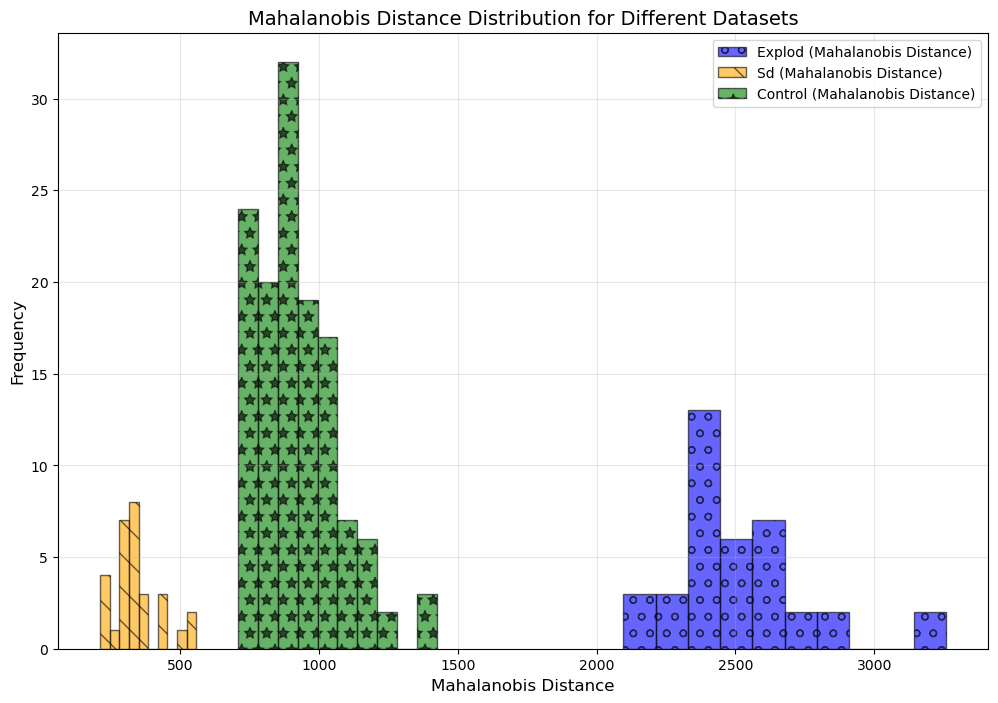

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

# Load datasets
datasets = {
    "explod": pd.read_csv("md_ex.csv"),  # Update with the correct file name if necessary
    "sd": pd.read_csv("md_sd.csv"),
    "control": pd.read_csv("md_control.csv")  # Update with the correct file name if necessary
}

# Define colors and hatching patterns for each dataset
colors = {"explod": "blue", "sd": "orange", "control": "green"}
hatch_styles = {"explod": "o", "sd": "\\", "control": "*"}

# Plotting function
def plot_mahalanobis_distribution(bins=20):
    plt.figure(figsize=(12, 8))
    
    # Plot Mahalanobis Distance for each dataset
    for dataset_name, df in datasets.items():
        if "Mahalanobis Distance" in df.columns:
            values = df["Mahalanobis Distance"].tolist()
            plt.hist(
                values,
                bins=bins,
                alpha=0.6,
                label=f"{dataset_name.capitalize()} (Mahalanobis Distance)",
                color=colors[dataset_name],
                hatch=hatch_styles[dataset_name],
                edgecolor="black"
            )
    
    # Customize plot
    plt.title("Mahalanobis Distance Distribution for Different Datasets", fontsize=14)
    plt.xlabel("Mahalanobis Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Plot the Mahalanobis Distance distribution
plot_mahalanobis_distribution(bins=10)


import pandas as pd

# Load the CSV file with Mahalanobis distances and image paths
df_md_ex = pd.read_csv("md_ex.csv")
df_md_sd = pd.read_csv("md_sd.csv")
df_md_control = pd.read_csv("md_control.csv")

# Print the paths (or the entire DataFrame if needed)
print("Paths for md_ex.csv:")
print(df_md_ex["Distance_Path"])

print("\nPaths for md_sd.csv:")
print(df_md_sd["Distance_Path"])

print("\nPaths for md_control.csv:")
print(df_md_control["Distance_Path"])

print(df_md_ex["Distance_Path"][0])


import pandas as pd
import shutil
import os

# Function to copy images to a new directory based on sorted distances with filenames as the Mahalanobis Distance
def copy_images_based_on_distance(csv_files, target_directory):
    all_data = []  # List to store data from all CSV files
    
    # Read and append data from each CSV file
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        all_data.append(df)

    # Combine data from all CSV files into one DataFrame
    combined_df = pd.concat(all_data, ignore_index=True)

    # Sort the combined DataFrame based on Mahalanobis Distance
    combined_df_sorted = combined_df.sort_values(by="Mahalanobis Distance")

    # Create the target directory if it doesn't exist
    os.makedirs(target_directory, exist_ok=True)

    # Copy the images in ascending order of Mahalanobis Distance
    for _, row in combined_df_sorted.iterrows():
        # Extract the image path by splitting on the first underscore and ignoring the distance part
        path = row["Distance_Path"].split("_", 1)[1]  # This gets the path after the Mahalanobis distance
        
        # Extract the Mahalanobis distance as the new filename
        distance = row["Distance_Path"].split("_", 1)[0]  # This gets the Mahalanobis distance
        filename = f"{distance}_{os.path.basename(path)}"  # Combine distance with original filename
        
        # Copy the image to the target directory with the new filename
        shutil.copy2(path, os.path.join(target_directory, filename))

# Example use case: List of CSV files to process
csv_files = ["md_ex.csv", "md_sd.csv", "md_control.csv"]
target_directory = r"C:\Users\k54739\Bibi_new_thesis\thesis\sorted_Resize_d7tod10"
copy_images_based_on_distance(csv_files, target_directory)


# added 2 special close gps to evaluate

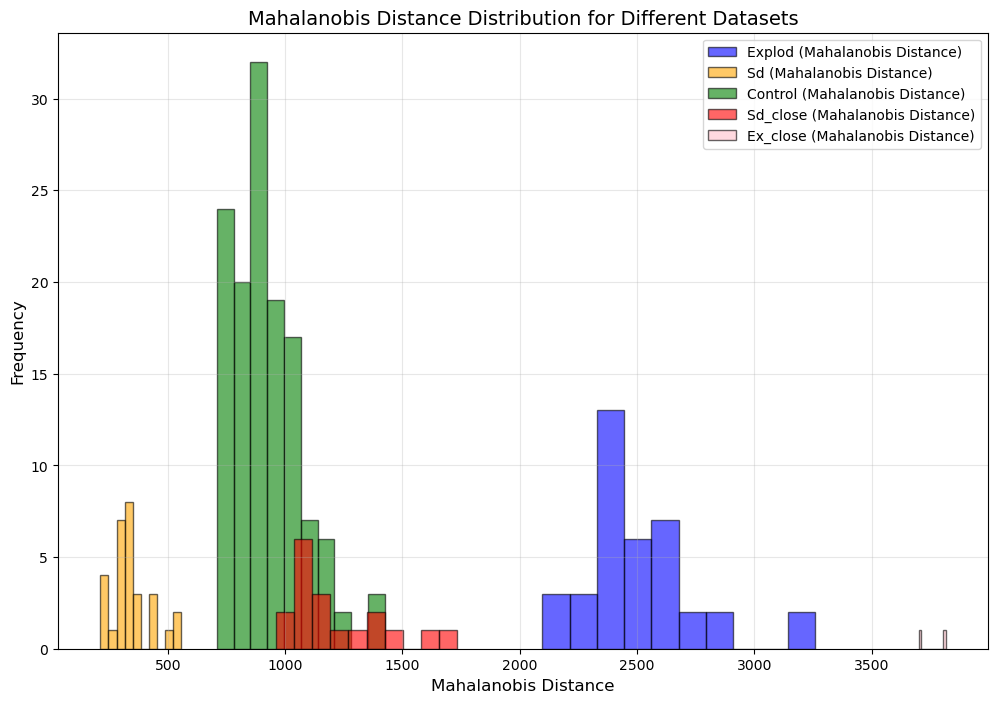

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# Load datasets
datasets = {
    "explod": pd.read_csv("md_ex.csv"),  # Update with the correct file name if necessary
    "sd": pd.read_csv("md_sd.csv"),
    "control": pd.read_csv("md_control.csv"),
    "sd_close": pd.read_csv("md_sd_close.csv"),
    "ex_close": pd.read_csv("md_ex_close.csv")   # Update with the correct file name if necessary
}

# Define colors and hatching patterns for each dataset
colors = {"explod": "blue", "sd": "orange", "control": "green","sd_close":"red","ex_close":"pink"}
#hatch_styles = {"explod": "o", "sd": "\\", "control": "*"}

# Plotting function
def plot_mahalanobis_distribution(bins=20):
    plt.figure(figsize=(12, 8))
    
    # Plot Mahalanobis Distance for each dataset
    for dataset_name, df in datasets.items():
        if "Mahalanobis Distance" in df.columns:
            values = df["Mahalanobis Distance"].tolist()
            plt.hist(
                values,
                bins=bins,
                alpha=0.6,
                label=f"{dataset_name.capitalize()} (Mahalanobis Distance)",
                color=colors[dataset_name],
                #hatch=hatch_styles[dataset_name],
                edgecolor="black"
            )
    
    # Customize plot
    plt.title("Mahalanobis Distance Distribution for Different Datasets", fontsize=14)
    plt.xlabel("Mahalanobis Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Plot the Mahalanobis Distance distribution
plot_mahalanobis_distribution(bins=10)


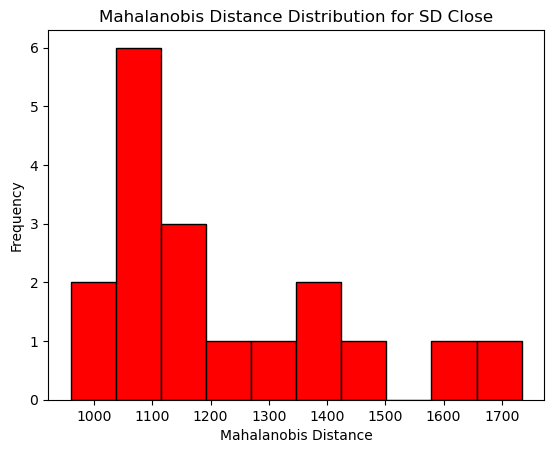

In [38]:
plt.hist(datasets["sd_close"]["Mahalanobis Distance"], bins=10, color="red", edgecolor="black")
plt.title("Mahalanobis Distance Distribution for SD Close")
plt.xlabel("Mahalanobis Distance")
plt.ylabel("Frequency")
plt.show()
